<a href="https://colab.research.google.com/github/ABD-01/Face-Unlock/blob/master/FaceNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image
from itertools import combinations 
from collections import OrderedDict
from tqdm import tqdm #, tqdm_notebook
from tqdm.notebook import tqdm as tqdm_notebook
 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
import torchvision.transforms as transforms

from typing import Callable, Optional
from  torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [4]:
torch.cuda.is_available()

False

In [18]:
import triplet_loss
from model import ResNet
from datasets import AttDataset

In [6]:
def seed_init():
    np.random.seed(0)
    random.seed(0)
    torch.manual_seed(0)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(0)
        torch.cuda.manual_seed_all(0)
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

seed_init()
# ref : https://discuss.pytorch.org/t/random-seed-initialization/7854/19


In [7]:
PATH = '/content/drive/MyDrive/Colab Notebooks/att_face_dataset/'

In [8]:
process = transforms.Compose([
    transforms.Resize((224,224), interpolation= transforms.InterpolationMode.BICUBIC),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.4422, std=0.1931),
])

In [9]:
dataset = AttDataset(PATH, transform=process)
dataset

Dataset AttDataset
    Number of datapoints: 400
    Root location: /content/drive/MyDrive/Colab Notebooks/att_face_dataset/
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bicubic)
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=0.4422, std=0.1931)
           )

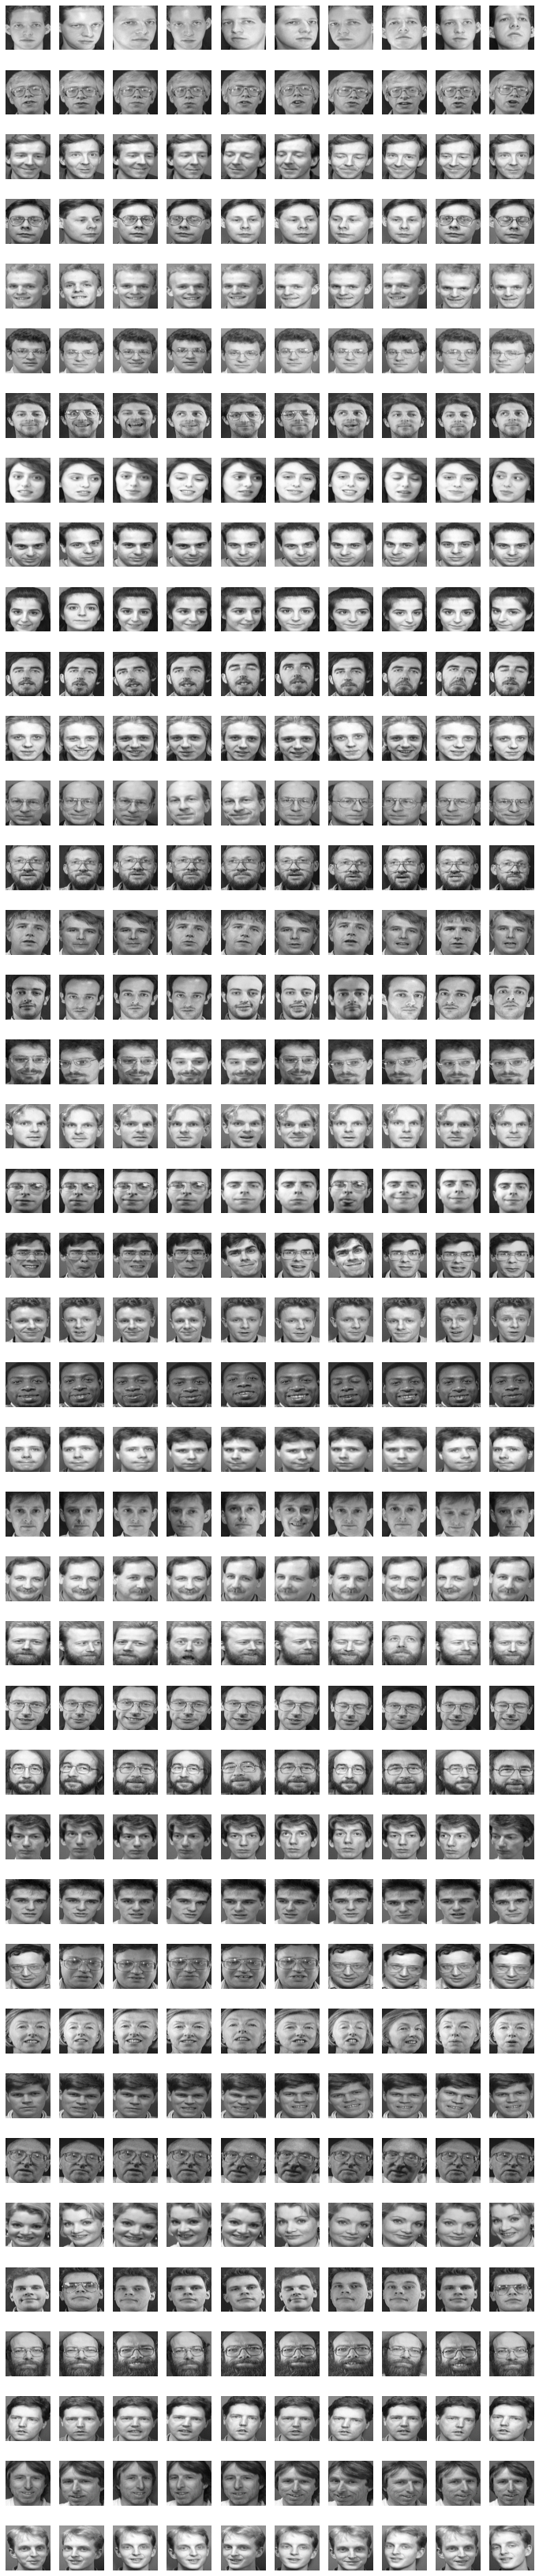

In [17]:
_,axxr = plt.subplots(40,10, figsize=(12,60))
for i, ax in enumerate(axxr.flatten()):
    ax.imshow(dataset[i][0].squeeze(), cmap="gray")
    ax.axis('off')
plt.axis('off')
plt.show()
# for i in range(40):
#     for j in range(10):
#         axxr[i][j].imshow(att_dataset[i][j].squeeze(), cmap='gray')
# plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
# # ref : https://stackoverflow.com/questions/25124143/matplotlib-subplots-get-rid-of-tick-labels-altogether
# plt.show()

In [19]:
resnet18 = ResNet()
resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (block1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block2): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(

In [25]:
!wget http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip

--2021-05-15 13:05:28--  http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip
Resolving vision.ucsd.edu (vision.ucsd.edu)... 132.239.95.98
Connecting to vision.ucsd.edu (vision.ucsd.edu)|132.239.95.98|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6206308 (5.9M) [application/zip]
Saving to: ‘yalefaces.zip’

yalefaces.zip       100%[===================>]   5.92M   671KB/s    in 9.2s    

2021-05-15 13:05:37 (662 KB/s) - ‘yalefaces.zip’ saved [6206308/6206308]



In [27]:
!unzip yalefaces.zip

Archive:  yalefaces.zip
   creating: yalefaces/
  inflating: yalefaces/Readme.txt    
   creating: __MACOSX/
   creating: __MACOSX/yalefaces/
  inflating: __MACOSX/yalefaces/._Readme.txt  
  inflating: yalefaces/subject01.gif  
  inflating: yalefaces/subject01.glasses  
  inflating: yalefaces/subject01.glasses.gif  
  inflating: yalefaces/subject01.happy  
  inflating: yalefaces/subject01.leftlight  
  inflating: yalefaces/subject01.noglasses  
  inflating: yalefaces/subject01.normal  
  inflating: yalefaces/subject01.rightlight  
  inflating: yalefaces/subject01.sad  
  inflating: yalefaces/subject01.sleepy  
  inflating: yalefaces/subject01.surprised  
  inflating: yalefaces/subject01.wink  
  inflating: yalefaces/subject02.centerlight  
  inflating: yalefaces/subject02.glasses  
  inflating: yalefaces/subject02.happy  
  inflating: yalefaces/subject02.leftlight  
  inflating: yalefaces/subject02.noglasses  
  inflating: yalefaces/subject02.normal  
  inflating: yalefaces/subject02.r

In [28]:
d = AttDataset(path='/content/yalefaces')

RuntimeError: ignored

In [34]:
for i in range(1,16):
    print(f"subject{i:02d}", len(glob.glob(f'/content/yalefaces/subject{i:02d}*')))

subject01 12
subject02 11
subject03 11
subject04 11
subject05 11
subject06 11
subject07 11
subject08 11
subject09 11
subject10 11
subject11 11
subject12 11
subject13 11
subject14 11
subject15 11


In [ ]:
# Ref : http://vision.ucsd.edu/content/yale-face-database

In [37]:
class YalaDataset(Dataset):
    def __init__(self, path: str, tranform: Optional[Callable] = ToTensor()):
        super(YalaDataset, self).__init__()

        self.class_to_idx = self._find_classes(path)
        self.sample = make_dataset(path)

    def _find_classes(path):
        classes = [f'subject{i:02d}' for in range(1,16)]

[]

In [46]:
[d.name for d in os.scandir("/content/yalefaces") if 'subject' in d.name]

['subject15.glasses',
 'subject15.sad',
 'subject04.glasses',
 'subject03.surprised',
 'subject14.centerlight',
 'subject03.leftlight',
 'subject11.normal',
 'subject05.wink',
 'subject04.surprised',
 'subject06.normal',
 'subject14.surprised',
 'subject15.normal',
 'subject14.glasses',
 'subject10.surprised',
 'subject10.normal',
 'subject02.wink',
 'subject10.leftlight',
 'subject14.normal',
 'subject12.noglasses',
 'subject09.surprised',
 'subject04.happy',
 'subject01.sleepy',
 'subject05.sleepy',
 'subject14.sleepy',
 'subject15.leftlight',
 'subject05.happy',
 'subject13.centerlight',
 'subject12.wink',
 'subject15.surprised',
 'subject08.sleepy',
 'subject02.centerlight',
 'subject15.centerlight',
 'subject11.glasses',
 'subject05.rightlight',
 'subject01.glasses.gif',
 'subject07.happy',
 'subject12.rightlight',
 'subject05.surprised',
 'subject03.happy',
 'subject09.sleepy',
 'subject10.happy',
 'subject11.centerlight',
 'subject12.leftlight',
 'subject13.normal',
 'subject02.

In [38]:
dataset.class_to_idx

{'s01': 0,
 's02': 1,
 's03': 2,
 's04': 3,
 's05': 4,
 's06': 5,
 's07': 6,
 's08': 7,
 's09': 8,
 's10': 9,
 's11': 10,
 's12': 11,
 's13': 12,
 's14': 13,
 's15': 14,
 's16': 15,
 's17': 16,
 's18': 17,
 's19': 18,
 's20': 19,
 's21': 20,
 's22': 21,
 's23': 22,
 's24': 23,
 's25': 24,
 's26': 25,
 's27': 26,
 's28': 27,
 's29': 28,
 's30': 29,
 's31': 30,
 's32': 31,
 's33': 32,
 's34': 33,
 's35': 34,
 's36': 35,
 's37': 36,
 's38': 37,
 's39': 38,
 's40': 39}

In [49]:
!mv /content/yalefaces '/content/drive/MyDrive/Colab Notebooks/yalefaces'